## Problema con Solución Analítica – Ecuación de Helmholtz en un Medio Acústico

Se considera un medio acústico homogéneo: **aire a 20°C y 1 atmósfera de presión**. En estas condiciones, la **velocidad del sonido** se toma como:

$$
c = 344 \ \text{m/s}
$$

La frecuencia de excitación elegida es:

$$
f = 400 \ \text{Hz}
$$

El **número de onda** correspondiente se calcula como:

$$
k = \frac{2\pi f}{c} = \frac{2\pi \cdot 400}{344} \approx 7.31
$$

### Solución Analítica

Se define el **potencial de velocidad** como:

$$
\phi(p) = \sin\left(k \sqrt{2} \, p_1\right) \cdot \sin\left(k \sqrt{2} \, p_2\right)
$$

donde $ p = (p_1, p_2) $ es un punto en el dominio cuadrado \( [0, 0.1] \times [0, 0.1] \).

Esta función es una **solución exacta** de la ecuación de Helmholtz bidimensional:

$$
\nabla^2 \phi + k^2 \phi = 0
$$

### Condiciones de Contorno – Velocidad Normal

Las condiciones de contorno se obtienen derivando \(\phi(p)\) con respecto a la dirección normal en cada lado del cuadrado. Se considera que la normal apunta hacia afuera del dominio.

Las **velocidades normales** en los bordes del cuadrado son:

- En $ p_1 = 0 $:  
  $$
  v(p) = 0
  $$
  
- En $ p_2 = 0 $:  
  $$
  v(p) = 0
  $$

- En $ p_1 = 0.1 $:  
  $$
  v(p) = k\sqrt{2} \cdot \cos\left(k\sqrt{2} \cdot 0.1\right) \cdot \sin\left(k\sqrt{2} \cdot p_2\right)
  $$

- En $ p_2 = 0.1 $:  
  $$
  v(p) = k\sqrt{2} \cdot \sin\left(k\sqrt{2} \cdot p_1\right) \cdot \cos\left(k\sqrt{2} \cdot 0.1\right)
  $$

Estas condiciones de frontera se utilizan como datos para validar implementaciones numéricas (como el Método de los Elementos de Frontera – BEM).


In [2]:
from funciones_helmholtz import *
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve
# reload kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


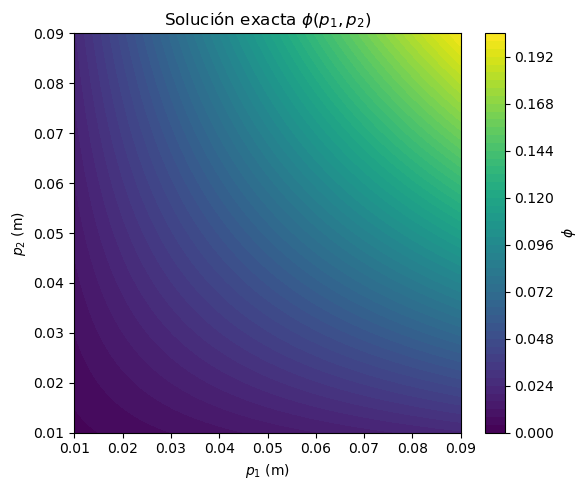

In [3]:
# Parámetros físicos
k = 7.31    # número de onda
# Parámetros del dominio
L = 0.1            # Longitud del lado del cuadrado
n_per_side = 10    # Número de elementos por lado
h = L / n_per_side

# Definir solución exacta
def phi(p1, p2):
    factor = k / np.sqrt(2)
    return np.sin(factor * p1) * np.sin(factor * p2)

# Crear una malla del dominio [0, 0.1] x [0, 0.1]
L = 0.1
n = 100
p1_vals = np.linspace(h, L-h, n)
p2_vals = np.linspace(h, L-h, n)
P1, P2 = np.meshgrid(p1_vals, p2_vals)

# Evaluar phi en la malla
Phi = phi(P1, P2)

# Graficar
plt.figure(figsize=(6, 5))
contour = plt.contourf(P1, P2, Phi, levels=50, cmap='viridis')
plt.title(r'Solución exacta $\phi(p_1, p_2)$')
plt.xlabel('$p_1$ (m)')
plt.ylabel('$p_2$ (m)')
plt.colorbar(contour, label=r'$\phi$')
plt.tight_layout()
plt.show()

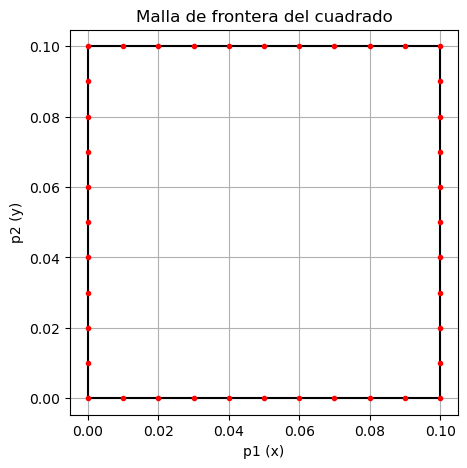

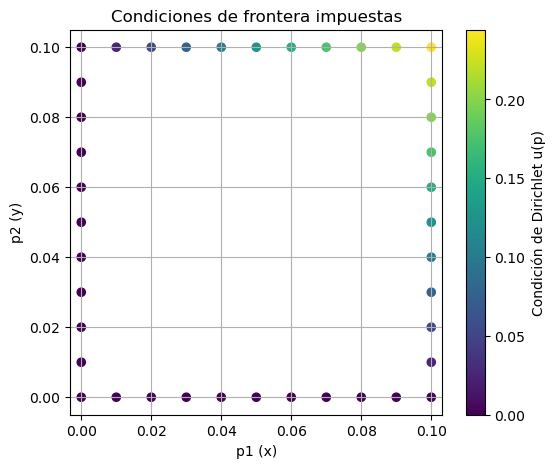

In [4]:


# Coordenadas de nodos por lado
# Lado inferior (p2 = 0)
bottom = np.array([[i*h, 0.0] for i in range(n_per_side)])
# Lado derecho (p1 = L)
right = np.array([[L, i*h] for i in range(n_per_side)])
# Lado superior (p2 = L)
top = np.array([[L - i*h, L] for i in range(n_per_side)])
# Lado izquierdo (p1 = 0)
left = np.array([[0.0, L - i*h] for i in range(n_per_side)])

# Concatenar coordenadas en orden antihorario
coords = np.vstack([bottom, right, top, left])
n_nodes = coords.shape[0]

# Crear elementos (pares de nodos consecutivos)
elems = np.array([[i, (i + 1) % n_nodes] for i in range(n_nodes)])

# Visualizar
plt.figure(figsize=(5, 5))
for e in elems:
    x_coords = coords[e, 0]
    y_coords = coords[e, 1]
    plt.plot(x_coords, y_coords, 'k-')
plt.plot(coords[:, 0], coords[:, 1], 'ro', markersize=3)
plt.axis("equal")
plt.title("Malla de frontera del cuadrado")
plt.xlabel("p1 (x)")
plt.ylabel("p2 (y)")
plt.grid(True)
plt.show()

# Ensamblar matrices de influencia
Gmat, Hmat = assem(coords, elems,k)

# Inicializar arreglo de u_boundary (condiciones de Dirichlet en cada nodo) como valores complejos
u_boundary = np.zeros(n_nodes)

for i, (x, y) in enumerate(coords):
    if np.isclose(x, 0.0):  # Lado izquierdo
        u_boundary[i] = 0.0
    elif np.isclose(y, 0.0):  # Lado inferior
        u_boundary[i] = 0.0
    elif np.isclose(x, L):  # Lado derecho
        u_boundary[i] =   np.sin(k / np.sqrt(2) * L) * np.sin(k / np.sqrt(2) * y)
    elif np.isclose(y, L):  # Lado superior
        u_boundary[i] =   np.sin(k / np.sqrt(2) * x) * np.sin(k / np.sqrt(2) * L)

q_boundary = solve(Gmat, Hmat.dot(u_boundary))
#u_boundary = solve(Hmat, Gmat.dot(q_boundary))

# Extraer coordenadas de los nodos
x_vals = coords[:, 0]
y_vals = coords[:, 1]

# Graficar u_boundary en función de la posición sobre la frontera
plt.figure(figsize=(6, 5))
sc = plt.scatter(x_vals, y_vals, c=u_boundary, cmap='viridis', s=35)
plt.colorbar(sc, label='Condición de Dirichlet u(p)')
plt.title("Condiciones de frontera impuestas")
plt.xlabel("p1 (x)")
plt.ylabel("p2 (y)")
plt.axis("equal")
plt.grid(True)
plt.show()

# Dominio cuadrado
L = 0.1

# Crear una malla regular de puntos internos
n_int = 100  # resolución de puntos internos por eje
x_vals = np.linspace(h, L - h, n_int)  # evitar la frontera
y_vals = np.linspace(h, L - h, n_int)
X, Y = np.meshgrid(x_vals, y_vals)
ev_coords = np.vstack([X.ravel(), Y.ravel()]).T  # shape: (n_points, 2)



In [5]:
# Evaluar solución en puntos internos
solution = eval_sol(ev_coords, coords, elems, u_boundary, q_boundary,k)

In [6]:
# Puntos interiores a evaluar
eval_points = np.array([
    [0.025, 0.025],
    [0.075, 0.025],
    [0.075, 0.075],
    [0.05,  0.05]
])

# Asegúrate de que u_boundary y q_boundary ya están definidos
# Por ejemplo, u_boundary podría ser el valor analítico φ en los puntos medios de los elementos

# Evaluar solución en puntos interiores
sol_interior = eval_sol(eval_points, coords, elems, u_boundary, q_boundary, k=7.31)

# Mostrar resultados
for i, pt in enumerate(eval_points):
    print(f"φ({pt}) ≈ {sol_interior[i]:.6f}")

φ([0.025 0.025]) ≈ 0.006240-0.002619j
φ([0.075 0.025]) ≈ 0.020682-0.006250j
φ([0.075 0.075]) ≈ 0.085753+0.007933j
φ([0.05 0.05]) ≈ 0.035563-0.001954j


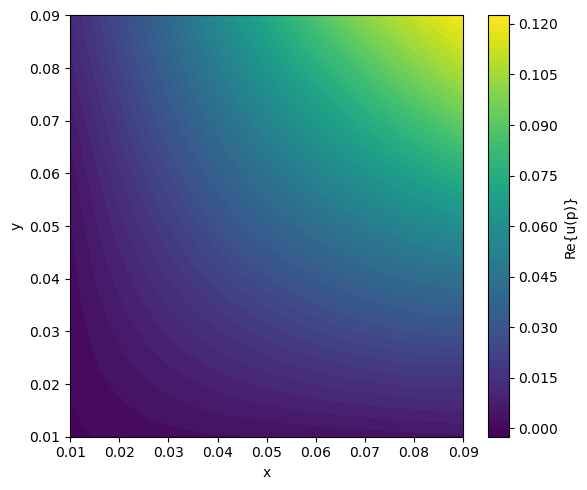

In [7]:
# Asegúrate de usar la parte real (o imag/abs) para graficar
solution_real = np.real(solution)

# Graficar
plt.figure(figsize=(6, 5))
plt.tricontourf(ev_coords[:, 0], ev_coords[:, 1], solution_real, levels=50, cmap='viridis')
plt.colorbar(label=r'Re{u(p)}')
plt.xlabel("x")
plt.ylabel("y")
#plt.grid(True)
plt.tight_layout()
plt.show()